In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from training.encoder import CourseEncoder


device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", device)


# Load course data ------------------------------------------------------------------------------
df = pd.read_csv("../data/cleaned_courses.csv")
texts = df["TextForBERT"].astype(str).tolist()
print("N texts:", len(texts))

# Vanilla BERT Initialization -------------------------------------------------------------------
vanilla_name = "bert-base-uncased"
tok_v = AutoTokenizer.from_pretrained(vanilla_name)
model_v = AutoModel.from_pretrained(vanilla_name).to(device)
model_v.eval()

# Trained contrastive model initialization ------------------------------------------------------

trained_dir = "model_v7_0.2"

tok_t = AutoTokenizer.from_pretrained(trained_dir)
model_t = CourseEncoder(base_model_name="bert-base-uncased", proj_dim=256)
state = torch.load(f"{trained_dir}/pytorch_model.bin", map_location=device)
model_t.load_state_dict(state)
model_t.to(device)
model_t.eval()

Using: cuda
N texts: 518


CourseEncoder(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

In [2]:
import torch.nn.functional as F
from transformers import PreTrainedModel
def embed_texts(texts, tokenizer, model, batch_size=32, max_len=64):
    '''
    Function used to return course embeddings, based on base_bert.py
    '''
    all_embs = []
    model.eval()
    # check if the model being called is vanilla BERT
    is_vanilla = isinstance(model, PreTrainedModel)

    # embedding setup
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            enc = tokenizer(
                batch,
                padding=True,
                truncation=True,
                max_length=max_len,
                return_tensors="pt"
            ).to(device)

            if is_vanilla:
                # tokenize and normalize
                out = model(**enc)
                cls = out.last_hidden_state[:, 0, :]
                embs = F.normalize(cls, p=2, dim=-1)
            else:
                # CourseEncoder already returns normalized embeddings
                embs = model(
                    input_ids=enc["input_ids"],
                    attention_mask=enc["attention_mask"],
                )

            all_embs.append(embs.cpu().numpy())

    return np.vstack(all_embs)


In [3]:
emb_v = embed_texts(texts, tok_v, model_v)  # vanilla BERT
emb_t = embed_texts(texts, tok_t, model_t)  # trained contrastive encoder

print("Vanilla embeddings:", emb_v.shape)
print("Trained embeddings:", emb_t.shape)

Vanilla embeddings: (518, 768)
Trained embeddings: (518, 256)



Vanilla BERT
Mean cosine: 0.81806767
Std  cosine: 0.053812627


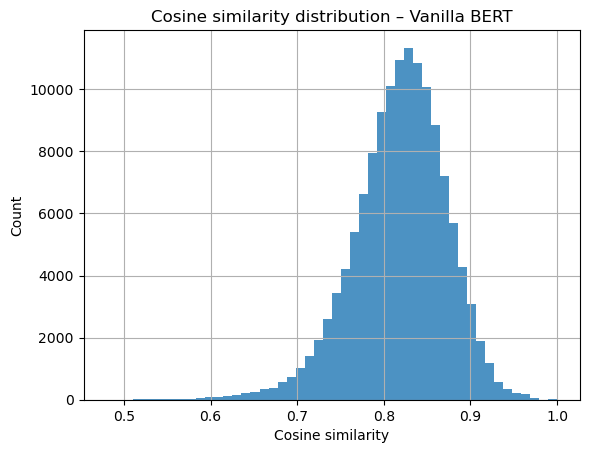


Fine-tuned BERT
Mean cosine: 0.015737895
Std  cosine: 0.32951468


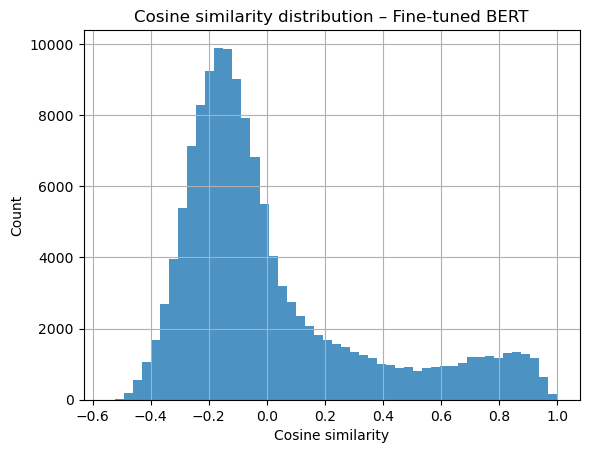

In [4]:
from output import cosine_stats_and_plot

cosine_stats_and_plot(emb_v, "Vanilla BERT")
cosine_stats_and_plot(emb_t, "Fine-tuned BERT")


In [5]:
from output import get_top_n_recommendations, print_recommendations

# load student data
df_s = pd.read_csv("../data/students_clean.csv")
texts_s = df_s["StudentText"].astype(str).tolist()
len(texts), texts_s[0][:200]

# embed student texts using trained model
embeddings_s = embed_texts(texts_s, tok_t, model_t)
print(embeddings_s.shape)  # (num_students, 256)

student_index = 7
student_emb = embeddings_s[student_index]

top_df = get_top_n_recommendations(
    student_emb=student_emb,
    course_embs=emb_t,
    course_df=df,
    top_n=5,
)

print_recommendations(top_df) # print recommendation

(600, 256)

Top 5 recommended courses:

401. MCG 3305 [similarity: 0.7447]
   Title: Biomedical System Dynamics 
   Desc : Modeling of mechanical, fluid, thermal and biomedical systems using a lumped parameter approach. Concepts of through and across variables in systems. Block diagrams for system representation. Linearization and solution of system equations. Transient and frequency response of biomedical systems.

402. MCG 3306 [similarity: 0.6986]
   Title: System Dynamics 
   Desc : Modelling of mechanical, electrical, fluid and thermal systems using lumped parameter approach. Concepts of through and across variables in systems. Block diagram for system representation. Linearization and solution of system equations. Transient and frequency response of physical systems.

399. MCG 3143 [similarity: 0.6903]
   Title: Biofluid Mechanics 
   Desc : Fundamentals of the human cardiovascular and respiratory systems. Differential treatment of fluid motion. Computational fluid dynamics.  Non

In [6]:
import umap
reducer_v = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    random_state=42,
)
emb_v_umap = reducer_v.fit_transform(emb_v)

reducer_t = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    random_state=42,
)
emb_t_umap = reducer_t.fit_transform(emb_t)
student_umap = reducer_t.transform(student_emb.reshape(1, -1))
top_indices = top_df.index.to_numpy()

c:\Users\yhila\anaconda3\envs\elg5255\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\yhila\anaconda3\envs\elg5255\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


C:\Users\yhila\AppData\Local\Temp\ipykernel_26532\2931004866.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_prefixes))


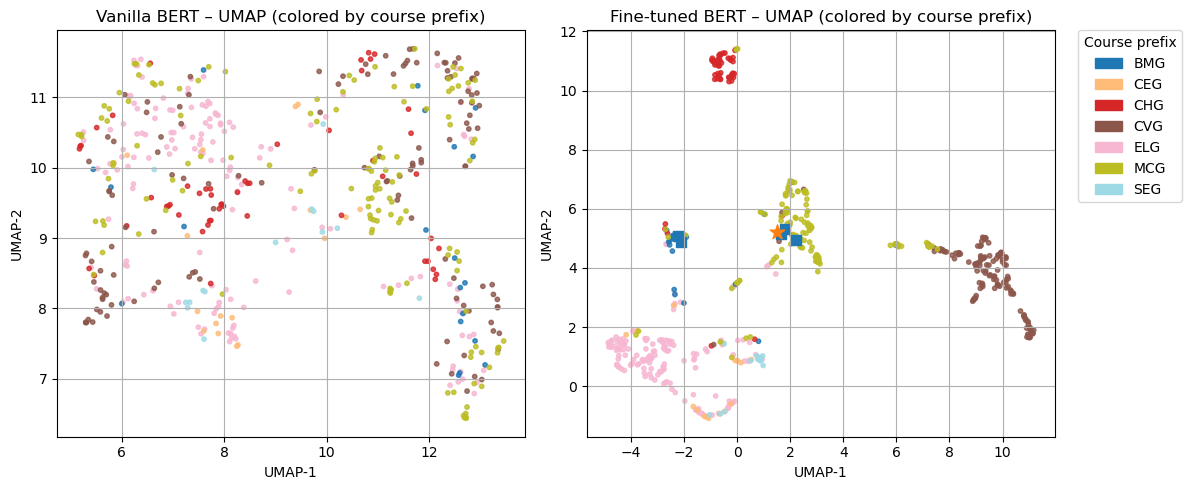

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Build prefixes and colors
prefixes = df["Faculty"].str.extract(r"([A-Za-z]+)")[0]
unique_prefixes = sorted(prefixes.unique())
mapping = {p: i for i, p in enumerate(unique_prefixes)}
colors = prefixes.map(mapping).values

# UMAP embeddings already computed: emb_v_umap, emb_t_umap

cmap = plt.cm.get_cmap('tab20', len(unique_prefixes))

plt.figure(figsize=(12, 5))

# Vanilla
plt.subplot(1, 2, 1)
plt.scatter(
    emb_v_umap[:, 0],
    emb_v_umap[:, 1],
    s=10,
    c=colors,
    cmap=cmap,
    alpha=0.8,
)
plt.title("Vanilla BERT – UMAP (colored by course prefix)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)

# Fine-tuned
plt.subplot(1, 2, 2)
plt.scatter(
    emb_t_umap[:, 0],
    emb_t_umap[:, 1],
    s=10,
    c=colors,
    cmap=cmap,
    alpha=0.8,
)

# highlight the student's top-N recommended courses
plt.scatter(
    emb_t_umap[top_indices, 0],
    emb_t_umap[top_indices, 1],
    s=60,
    marker="s",
)

# highlight the student embedding
plt.scatter(
    student_umap[0, 0],
    student_umap[0, 1],
    s=120,
    marker="*",
)

plt.title("Fine-tuned BERT – UMAP (colored by course prefix)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)

# Shared legend
handles = [
    mpatches.Patch(color=cmap(mapping[p]), label=p)
    for p in unique_prefixes
]

plt.legend(
    handles=handles,
    title="Course prefix",
    bbox_to_anchor=(1.05, 1.0),
    loc="upper left",
    borderaxespad=0.0,
)
plt.tight_layout()
plt.show()

In [8]:
from IsoScore.IsoScore import IsoScore

vanila_bert_iso_score = IsoScore(emb_v)
tuned_bert_iso_score = IsoScore(emb_t)

print(f"Vanilla Bert Isotropy score: {vanila_bert_iso_score}")
print(f"Tuned Bert Isotropy score: {tuned_bert_iso_score}")

Vanilla Bert Isotropy score: 0.024864181876182556
Tuned Bert Isotropy score: 0.03161368891596794
